Importing libraries

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
import json

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Reading the files into training and validation datasets with a 80%-20% split

In [3]:
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(
    'ECG_Image_data/train',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both'
)

class_names = train_dataset.class_names
train_batches = len(train_dataset)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    'ECG_Image_data/test',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
)

Found 3001 files belonging to 6 classes.
Using 2401 files for training.
Using 600 files for validation.
Found 24799 files belonging to 6 classes.


Prefetching data into GPU memory to optimize training process

In [4]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

Visualizing some training images

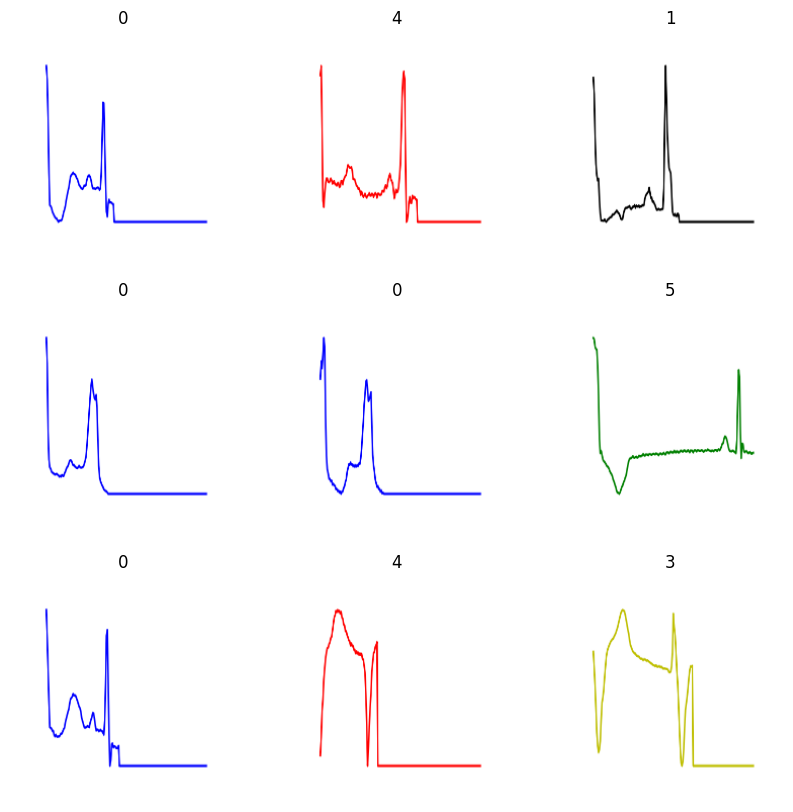

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Creating data augmentation layer 

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomHeight(0.1),
        layers.RandomWidth(0.1),
    ]
)

Visualizing the data augmentations on a random training image

In [7]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_dataset.take(1):
#     for i in range(9):
#         augmented_images = data_augmentation(images)
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(augmented_images[0].numpy().astype("uint8"))
#         plt.axis("off")

Define some key constants

In [8]:
num_classes = 6
image_size = (224, 224, 3)

Defining function to return AlexNet Model with reduced number of filters as per research paper

In [28]:
def make_alexnet_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Layer 1: Convolutional + Max Pooling
    # x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), strides=(4, 4), activation='relu', padding='valid')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)
    x = layers.BatchNormalization()(x)

    # Layer 2: Convolutional + Max Pooling
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)
    x = layers.BatchNormalization()(x)

    # Layer 3: Three Convolutional Layers
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Layer 4: Max Pooling
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(11, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return keras.Model(inputs, outputs)


Defining function to return VGG16 Model with reduced number of filters as per research paper

In [52]:
def make_vgg16_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    # x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 3
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 5
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(10, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

Defining function to return VGG19 Model with reduced number of filters as per research paper

In [48]:
def make_vgg19_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    # x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 3
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 5
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)


Training each model

In [55]:
from tqdm import tqdm
num_epochs = 10

models = {
    # "AlexNet": make_alexnet_model(input_shape=image_size, num_classes=num_classes),
    "VGG16": make_vgg16_model(input_shape=image_size, num_classes=num_classes),
    # "VGG19": make_vgg19_model(input_shape=image_size, num_classes=num_classes),
}

model_histories = {}

for name, model in models.items():
    print(f'\x1b[34mTraining {name} Model...\x1b[0m')
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    start = time.time()
        
    # Wrap model.fit with tqdm for a progress bar
    progress_bar = tqdm(total=num_epochs, position=0, leave=True)
    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=val_dataset,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: progress_bar.update(1)),
        ]
    )
    progress_bar.close()
    
    model_histories[name] = history
    
    end = time.time()
    print(f'Finished training {name} in {end-start:.2f}s\n')


Training VGG16 Model...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


In [54]:
model_results = {}

for name, model in models.items():
    model_results[name] = model.evaluate(test_dataset)

    print(f'\x1b[34m{name} Model Results:\x1b[0m')
    print(f"Test accuracy: {model_results[name][1]*100:.2f}%")
    print(f"Test loss: {model_results[name][0]:.4f}", end = '\n\n')


216/775 [=======>......................] - ETA: 14s - loss: 0.8924 - accuracy: 0.2342

KeyboardInterrupt: 

Defining function to plot model performance

In [32]:
def plot_model_performance(name, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.suptitle(f'{name} Model Results')
    plt.show()

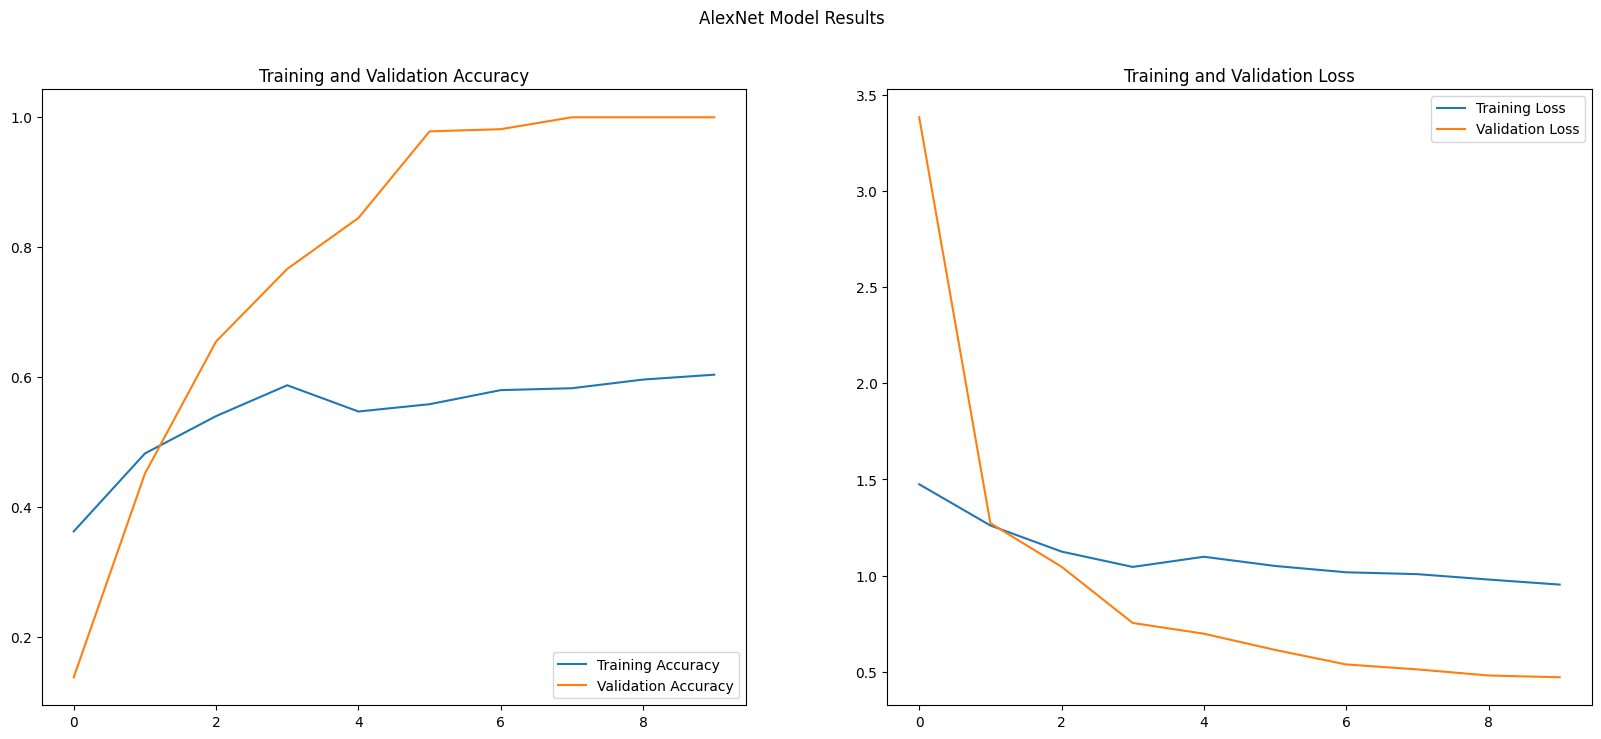

In [33]:
for name, history in model_histories.items():
    plot_model_performance(name, history)

Saving models and their training histories

In [42]:
for name, model in models.items():
    model.save(f'Saved Models/VERA/{name}-{model_results[name][1]*100:.2f}%.keras')
    print(f'Saved {name} Model')


for name, history in model_histories.items():
    with open(f'Model Histories/VERA/{name}-{model_results[name][1]*100:.2f}%.json', 'w') as json_file:
        json.dump(history.history, json_file)


Saved AlexNet Model


KeyboardInterrupt: 

## Loading trained model

In [ ]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(
    'Datasets/VERA/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both'
)

class_names = train_dataset.class_names
train_batches = len(train_dataset)

test_size = 0.2

# Calculate sizes for 80-20 split
train_size = int((1 - test_size) * train_batches)
test_size = int(test_size * train_batches)

# Split the dataset
test_dataset = train_dataset.skip(train_batches - test_size)
train_dataset = train_dataset.take(train_size)


def get_dataset_size(dataset):
    num_batches = len(dataset)
    return num_batches * 32

print(f"\nTotal number of samples in train_dataset: {get_dataset_size(train_dataset)} ({len(train_dataset)} batches of 32)")
print(f"Total number of samples in validation_dataset: {get_dataset_size(val_dataset)} ({len(val_dataset)} batches of 32)")
print(f"Total number of samples in test_dataset: {get_dataset_size(test_dataset)} ({len(test_dataset)} batches of 32)")

Found 2200 files belonging to 110 classes.
Using 1760 files for training.
Using 440 files for validation.

Total number of samples in train_dataset: 1408 (44 batches of 32)
Total number of samples in validation_dataset: 448 (14 batches of 32)
Total number of samples in test_dataset: 352 (11 batches of 32)


In [ ]:
alexnet_model = keras.models.load_model('Saved Models/VERA/AlexNet-98.86%.keras')
vgg16_model = keras.models.load_model('Saved Models/VERA/VGG16-94.89%.keras')
vgg19_model = keras.models.load_model('Saved Models/VERA/VGG19-97.44%.keras')

Text(0.5, 1.0, 'Predicted Class: 001-M\nActual Class: 001-M')

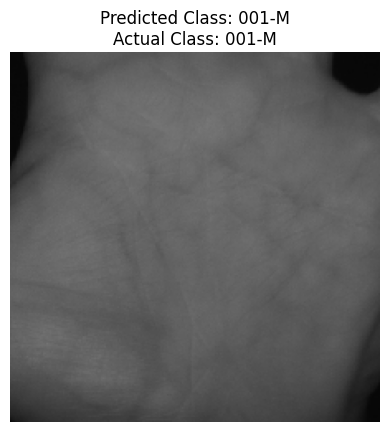

In [ ]:
class_to_test = 1 # Try any number from 1 to 110

img = keras.utils.load_img(
    f"Datasets/VERA/{class_names[class_to_test-1]}/01/{class_to_test:03d}_L_1_1.png", target_size=(224, 224)
)
plt.imshow(img)
plt.axis('off')

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

prediction = tf.argmax(vgg19_model.predict(img_array, verbose=0)[0]).numpy()

plt.title(f'Predicted Class: {class_names[prediction]}\nActual Class: {class_names[class_to_test-1]}')

In [ ]:
def evaluate_dataset(dataset):
    correct_predictions = 0
    total_samples = 0

    for images, labels in tqdm(dataset, desc="Evaluating Dataset With Decision Fusion", unit="batch"):
        batch_size = len(labels)

        for i in range(batch_size):
            img = images[i]
            label = labels[i]

            # Pre-process the image
            img_array = keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Get individual predictions
            prediction_alexnet = tf.argmax(alexnet_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg16 = tf.argmax(vgg16_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg19 = tf.argmax(vgg19_model.predict(img_array, verbose=0)[0]).numpy()

            # Assign weights based on correct or incorrect recognition
            weight_alexnet = 1 if prediction_alexnet == label else 0
            weight_vgg16 = 1 if prediction_vgg16 == label else 0
            weight_vgg19 = 1 if prediction_vgg19 == label else 0

            # Calculate the final decision
            final_decision = weight_alexnet + weight_vgg16 + weight_vgg19 

            # Update accuracy metrics
            correct_predictions += 1 if final_decision >= 2 else 0
            total_samples += 1

    # Calculate test accuracy
    test_accuracy = correct_predictions / total_samples
    return test_accuracy

accuracy = evaluate_dataset(test_dataset)
print(f"Test Accuracy: {accuracy:.2%}")


Evaluating Dataset With Decision Fusion: 100%|██████████| 11/11 [01:05<00:00,  5.91s/batch]

Test Accuracy: 98.86%


In [ ]:
def evaluate_dataset(dataset):
    correct_predictions = 0
    total_samples = 0

    for images, labels in tqdm(dataset, desc="Evaluating Dataset With Improved Decision Fusion", unit="batch"):
        batch_size = len(labels)

        for i in range(batch_size):
            img = images[i]
            label = labels[i]

            # Pre-process the image
            img_array = keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Get individual predictions
            prediction_alexnet = tf.argmax(alexnet_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg16 = tf.argmax(vgg16_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg19 = tf.argmax(vgg19_model.predict(img_array, verbose=0)[0]).numpy()

            predictions_list = [prediction_alexnet, prediction_vgg16, prediction_vgg19]

            joint_decision = max(set(predictions_list), key=predictions_list.count)

            # Update accuracy metrics
            correct_predictions += 1 if joint_decision == label else 0
            total_samples += 1

    # Calculate test accuracy
    test_accuracy = correct_predictions / total_samples
    return test_accuracy

accuracy = evaluate_dataset(test_dataset)
print(f"Test Accuracy: {accuracy:.2%}")


Evaluating Dataset With Improved Decision Fusion: 100%|██████████| 11/11 [01:03<00:00,  5.79s/batch]

Test Accuracy: 99.15%


In [ ]:
y = [model.evaluate(test_dataset, verbose=0)[1] for model in [alexnet_model, vgg16_model, vgg19_model]]
y.append(accuracy)

<Axes: >

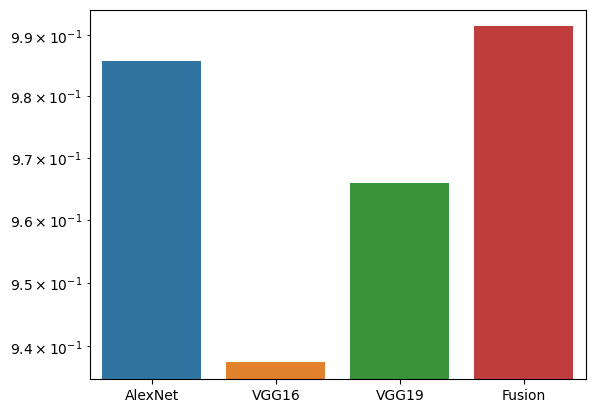

In [ ]:
import seaborn as sns

plt.yscale('log')
sns.barplot(y=y, x=['AlexNet', 'VGG16', 'VGG19', 'Fusion'])

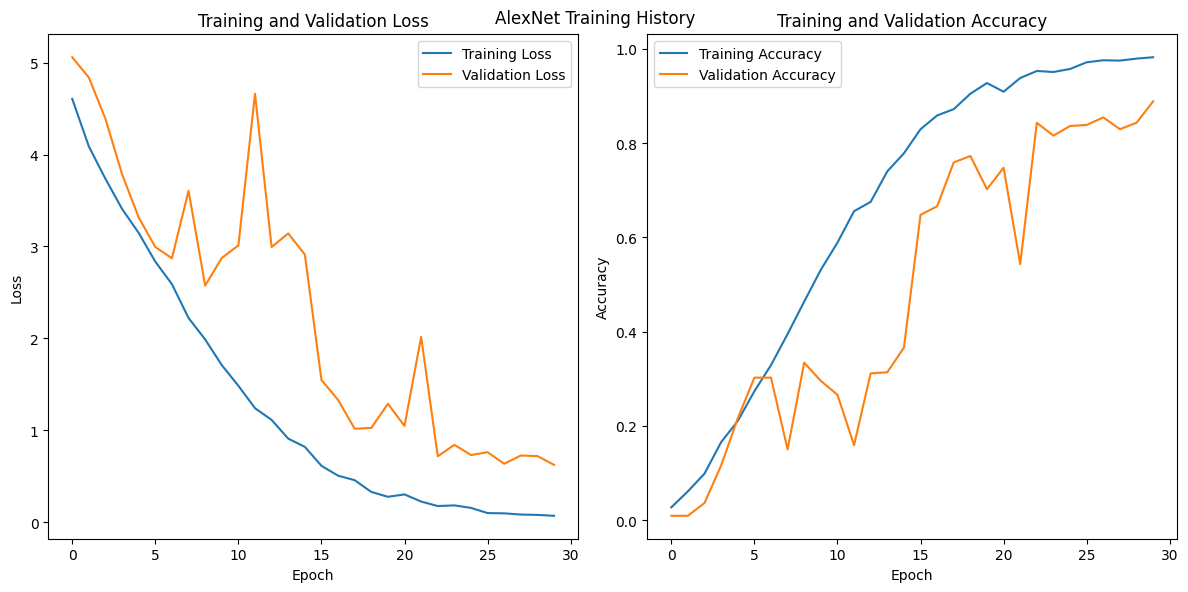

In [ ]:
import json
import matplotlib.pyplot as plt

# Load the JSON file
with open('Model Histories/VERA/AlexNet-98.86%.json', 'r') as f:
    history = json.load(f)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.suptitle('AlexNet Training History')
plt.show()


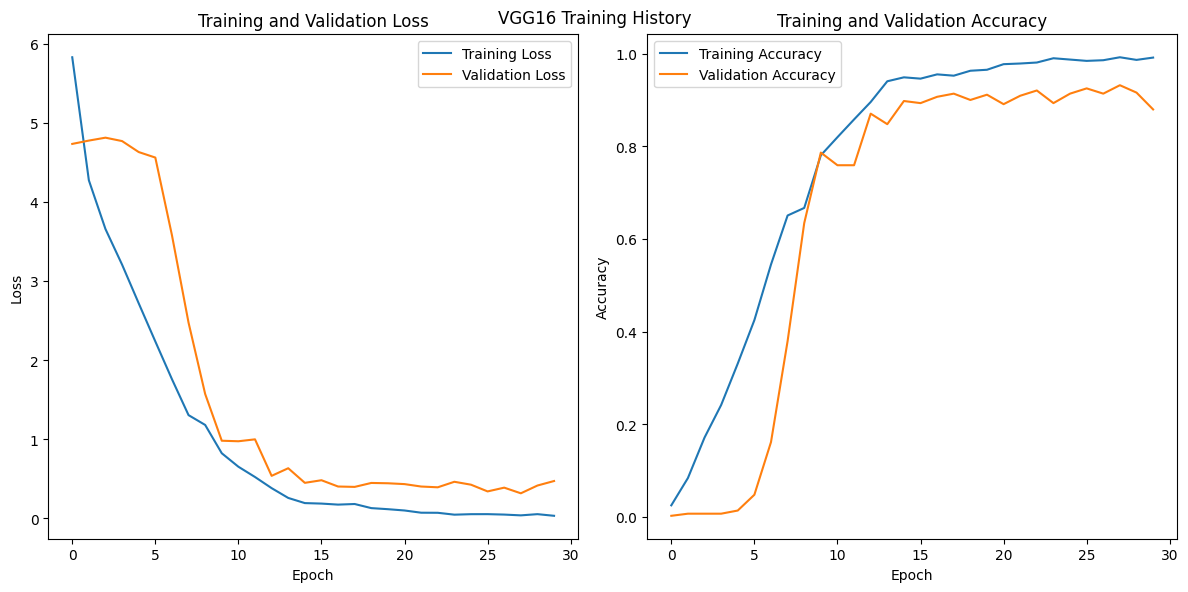

In [ ]:
import json
import matplotlib.pyplot as plt

# Load the JSON file
with open('Model Histories/VERA/VGG16-94.89%.json', 'r') as f:
    history = json.load(f)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.suptitle('VGG16 Training History')
plt.show()


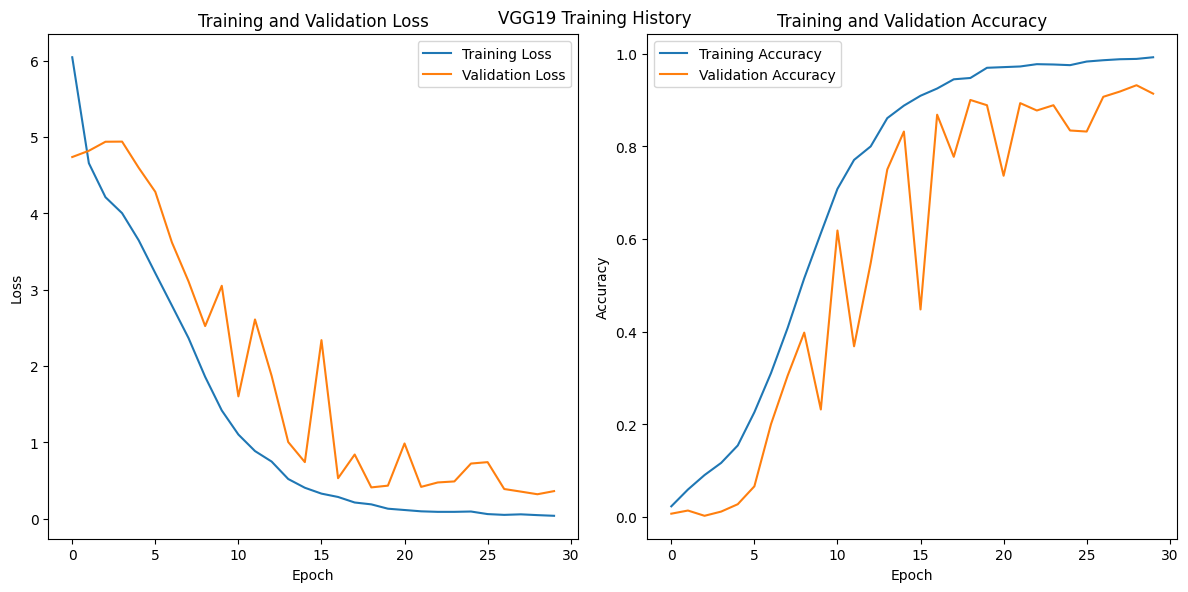

In [ ]:
import json
import matplotlib.pyplot as plt

# Load the JSON file
with open('Model Histories/VERA/VGG19-99.43%.json', 'r') as f:
    history = json.load(f)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.suptitle('VGG19 Training History')
plt.show()
